# Influence of Number of Training Epochs

In [33]:
import wandb
import pandas as pd
import pickle

## Retrieve data

In [ ]:
run_ids = []
with open('A_1_testing_num_epochs_ids.txt', 'r') as file:
    for line in file:
        run_ids.append(line.strip())


api = wandb.Api()
history_dict = {}
metrics = ["accuracy","eval_loss","train_st2_loss"]
for run_id in run_ids:
    run = api.run(f"ricu/fantastic-umbrella/{run_id}")
    
    # Fetch the 'num_train_epochs' value
    num_train_epochs = run.config['num_train_epochs']
    train_size = run.config["training_size"]
    seed = run.config["seed"]
    
    # Fetch the history and extract the 'accuracy' column
    history = run.scan_history(keys=["accuracy","eval_loss","train_st2_loss"])
    metrics = pd.DataFrame([row for row in history]).add_suffix(f'_{seed}')
    
    if train_size not in history_dict:
        history_dict[train_size] = {}
    # If 'num_train_epochs' is not in the dictionary, add it
    if num_train_epochs not in history_dict[train_size]:
        history_dict[train_size][num_train_epochs] = pd.DataFrame()

    history_dict[train_size][num_train_epochs] = pd.concat([history_dict[train_size][num_train_epochs],metrics],axis=1)
    
for num_train_epochs, accuracy in history_dict.items():
    print(f'num_train_epochs: {num_train_epochs}')
    print(accuracy)
history_dict = {k1: {k2: history_dict[k1][k2] for k2 in sorted(history_dict[k1])} for k1 in sorted(history_dict)}

# history_dict = {k: history_dict[k] for k in sorted(history_dict)}
with open('data/A_1_testing_num_epochs.pkl','wb') as f:
    pickle.dump(history_dict,f)

## Plot data

In [34]:
with open('data/A_1_testing_num_epochs.pkl','rb') as f:
    history_dict = pickle.load(f)

#### Plot median metric at each timestep

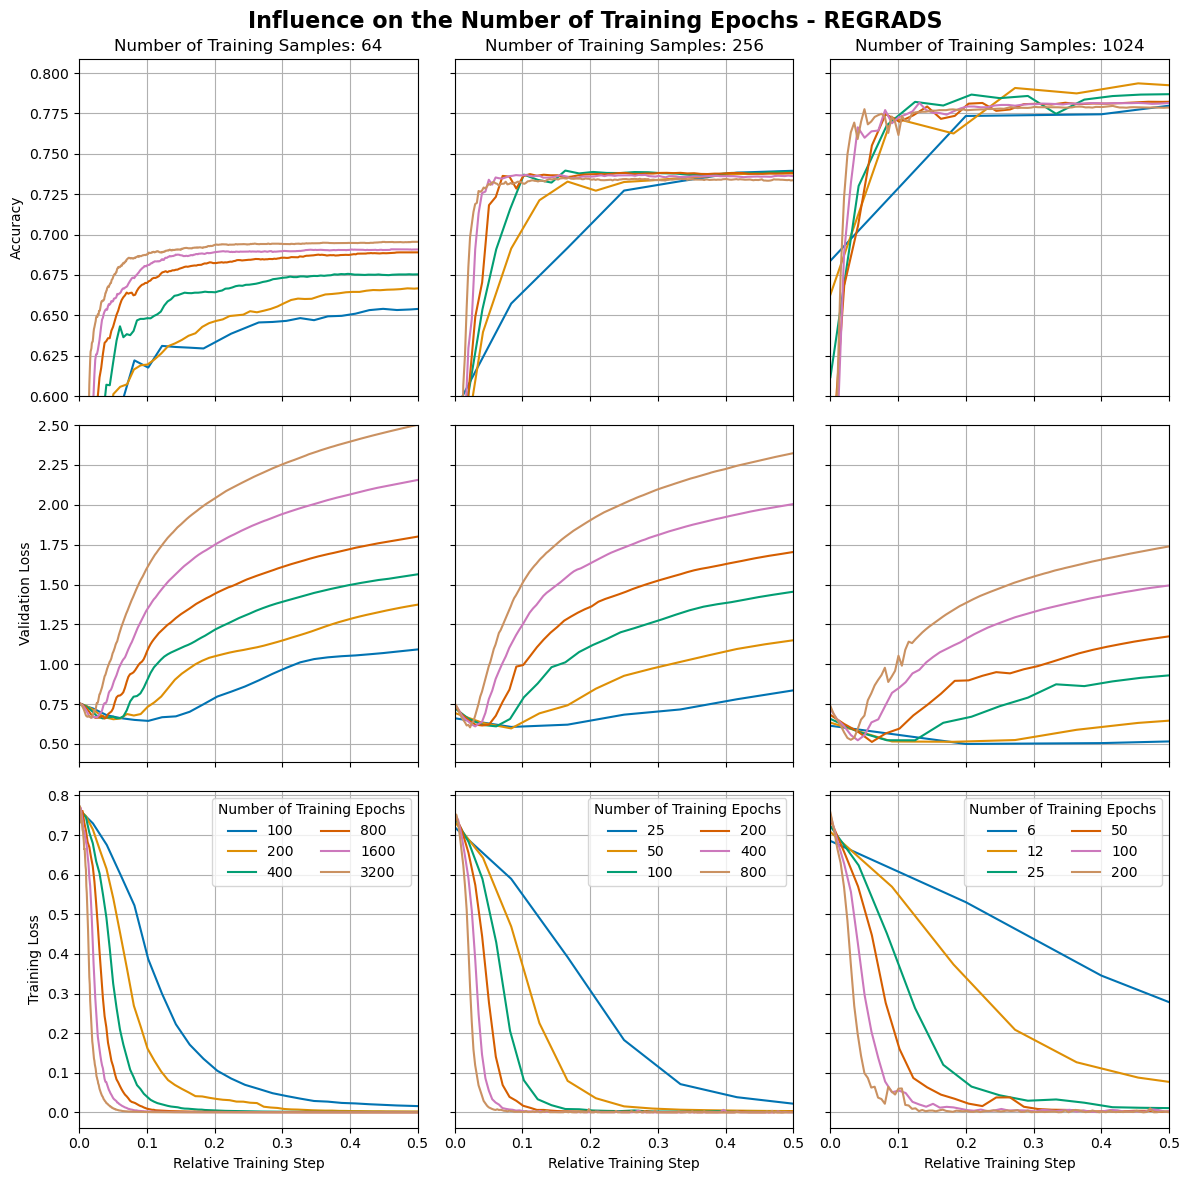

In [36]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

sns.set_palette('colorblind')
subplot_rows = ['accuracy', 'eval_loss', 'train_st2_loss']
row_names = {
    'accuracy': 'Accuracy',
    'eval_loss': 'Validation Loss',
    'train_st2_loss': 'Training Loss'
}

# Create a new figure
fig, axs = plt.subplots(
    3,
    len(subplot_rows),
    sharex=True,
    sharey='row',
    figsize = (12,12)
    # figsize = (TEXTWIDTH,TEXTWIDTH)
    )

for idy, (train_size, sub_dict) in enumerate(history_dict.items()):
    for idx, metric in enumerate(subplot_rows):
        ax = axs[idx,idy]
        for num_train_epochs, history_df in sub_dict.items():
            metric_columns = history_df.filter(regex=f'{metric}_').copy()
            # Compute the mean, standard deviation, and median
            metric_columns['mean'] = metric_columns.mean(axis=1)
            metric_columns['std'] = metric_columns.std(axis=1)
            metric_columns['median'] = metric_columns.median(axis=1)
        
            # Normalize the index (timesteps) to a range from 0 to 1
            normalized_index = metric_columns.index / metric_columns.index.max()
            # Plot the median on the respective subplot
            # label = f'{int(num_train_epochs*train_size/32)}'
            line, = axs[idx,idy].plot(
                normalized_index,
                metric_columns['mean'],
                label=f'{num_train_epochs}'
                )
            
            # color = line.get_color()
            # axs[idx,idy].plot(normalized_index, metric_columns['mean'] - metric_columns['std'], color=color, linestyle='--')
            # axs[idx,idy].plot(normalized_index, metric_columns['mean'] + metric_columns['std'], color=color, linestyle='--')
            # Add a shaded region for the standard deviation
            # axs[idx,idy].fill_between(normalized_index, (metric_columns['median'] - metric_columns['std']), (metric_columns['median'] + metric_columns['std']), alpha=1)
        if idy == 0:
            ax.set_ylabel(row_names[metric])
        if idx == 0 and idy == 2:
            ax.set_ylim(bottom=0.6)
        if idx == 0:
            ax.set_title(f'Number of Training Samples: {train_size}')
        if idx == len(history_dict) - 1:
            ax.set_xlabel('Relative Training Step')
            # axs[idx,idy].set_xlabel('Epoch')

        ax.grid(True,which='major')
        ax.grid(True,which='minor')
        ax.set_xlim([0,0.5])
        if idx == 1 and idy == 2:
            ax.set_ylim(top=2.5)
        if idx == 2:
            ax.legend(
                loc='upper right',
                ncol=2,
                title='Number of Training Epochs')
fig.suptitle('Influence on the Number of Training Epochs - REGRADS', fontsize=16,weight='bold')
# Show the plot
plt.tight_layout()
plt.savefig('img/A_1_testing_num_epochs_regrads.pdf', format='pdf')
plt.show()

### Standard Deviation

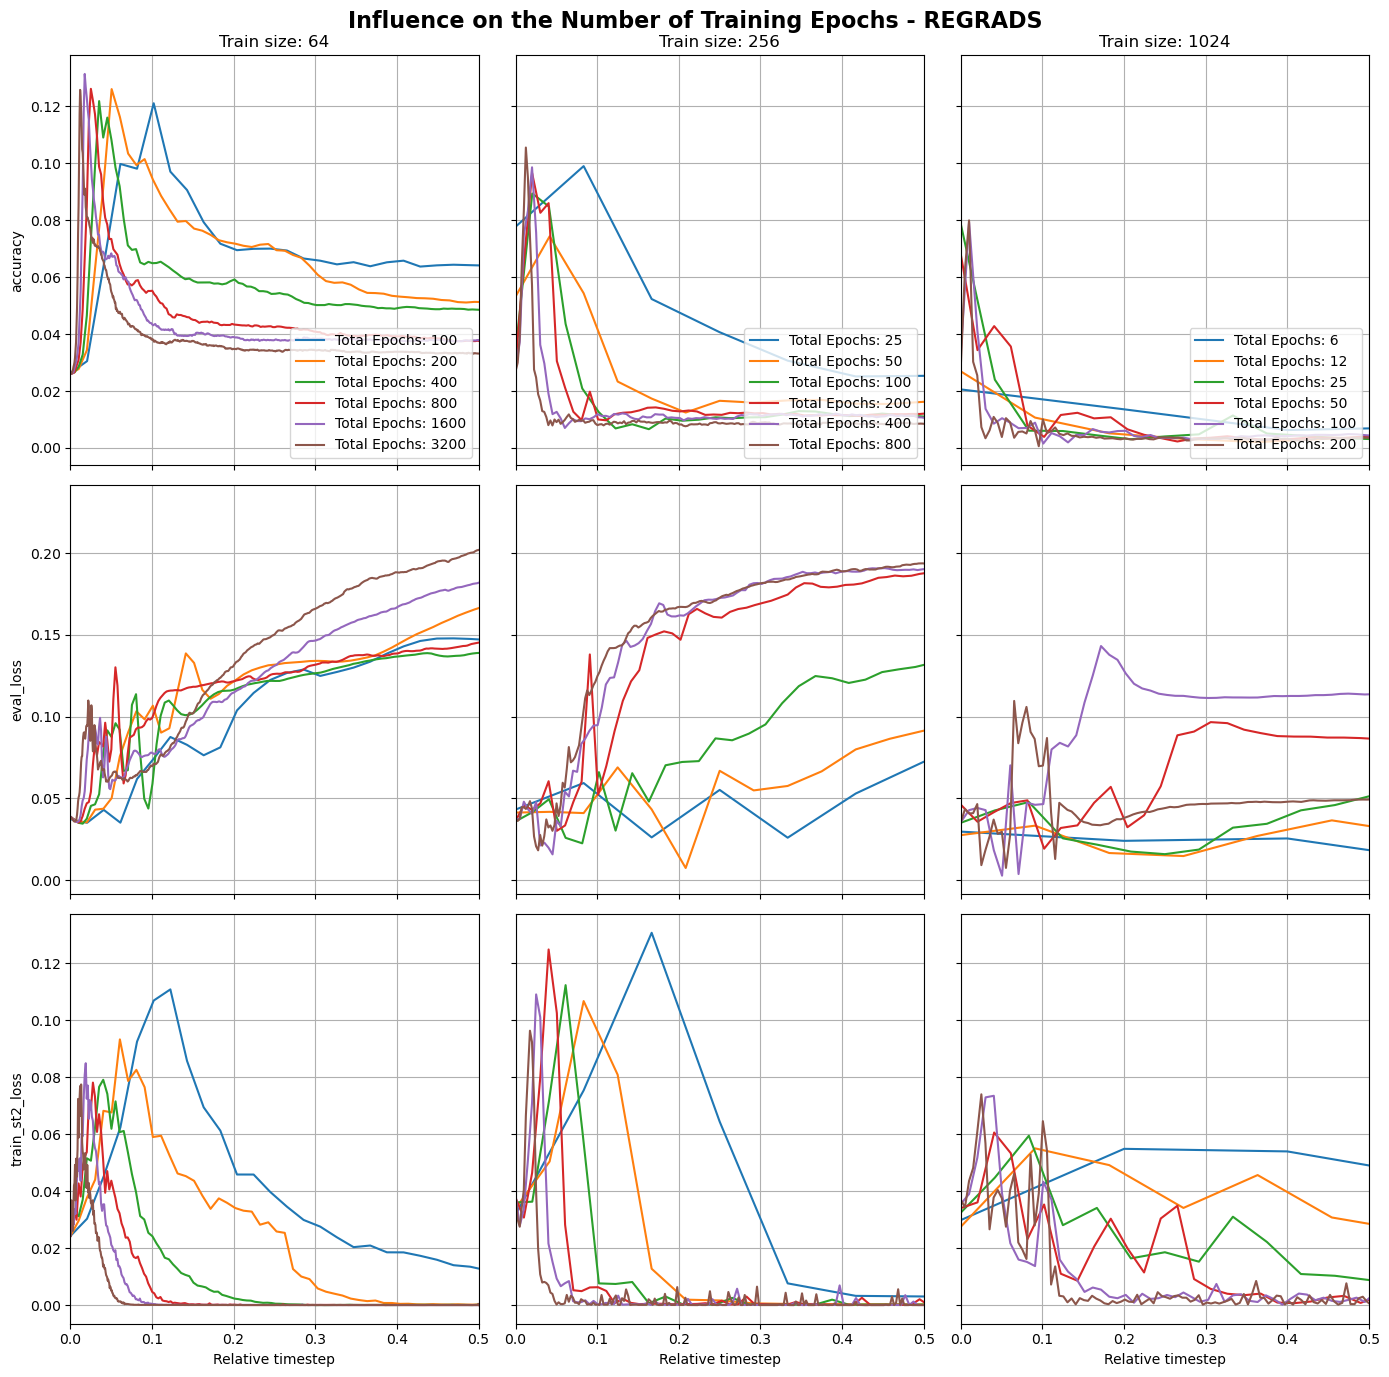

In [5]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'eval_loss', 'train_st2_loss']

# Create a new figure
fig, axs = plt.subplots(
    3,
    len(metrics),
    sharex=True,
    sharey='row',
    figsize = (14,14)
    # figsize = (TEXTWIDTH,TEXTWIDTH)
    )

for idy, (train_size, sub_dict) in enumerate(history_dict.items()):
    for idx, metric in enumerate(metrics):
        for num_train_epochs, history_df in sub_dict.items():
            metric_columns = history_df.filter(regex=f'{metric}_').copy()
            # Compute the mean, standard deviation, and median
            metric_columns['mean'] = metric_columns.mean(axis=1)
            metric_columns['std'] = metric_columns.std(axis=1)
            metric_columns['median'] = metric_columns.median(axis=1)
        
            # Normalize the index (timesteps) to a range from 0 to 1
            normalized_index = metric_columns.index / metric_columns.index.max()
            # Plot the median on the respective subplot
            line, = axs[idx,idy].plot(
                normalized_index,
                metric_columns['std'],
                label=f'Total Epochs: {num_train_epochs}'
                )
            
            # color = line.get_color()
            # axs[idx,idy].plot(normalized_index, metric_columns['mean'] - metric_columns['std'], color=color, linestyle='--')
            # axs[idx,idy].plot(normalized_index, metric_columns['mean'] + metric_columns['std'], color=color, linestyle='--')
            # Add a shaded region for the standard deviation
            # axs[idx,idy].fill_between(normalized_index, (metric_columns['median'] - metric_columns['std']), (metric_columns['median'] + metric_columns['std']), alpha=1)
        if idy == 0:
            axs[idx,idy].set_ylabel(metric)
        if idx == 0:
            axs[idx,idy].set_title(f'Train size: {train_size}')
        if idx == len(history_dict) - 1:
            axs[idx,idy].set_xlabel('Relative timestep')
            # axs[idx,idy].set_xlabel('Epoch')

        axs[idx,idy].grid(True,which='major')
        axs[idx,idy].grid(True,which='minor')
        axs[idx,idy].set_xlim([0,0.5])

        if idx == 0:
            axs[idx,idy].legend(loc='lower right')
fig.suptitle('Influence on the Number of Training Epochs - REGRADS', fontsize=16,weight='bold')
# Show the plot
plt.tight_layout()
# plt.savefig('img/A_1_testing_num_epochs_normalized.pdf', format='pdf')
plt.show()

# Vanilla

In [30]:
import wandb
import pandas as pd
import pickle
import seaborn as sns 
import functools
import operator 

## Retrieve data

In [ ]:
def read_wandb_csv(loc):
    df = pd.read_csv(loc)
    df.param_config_id = df.param_config_id.astype('str')
    return df

id_df = read_wandb_csv("data/A_1_testing_num_epochs_vanilla.csv")
id_df

In [6]:
run_ids = id_df["ID"]
from tqdm import tqdm


api = wandb.Api()
history_dict = {}
metrics = ["accuracy","eval_loss","train_st2_loss"]
for run_id in tqdm(run_ids):
    run = api.run(f"ricu/fantastic-umbrella/{run_id}")
    
    # Fetch the 'num_train_epochs' value
    num_train_epochs = run.config['num_train_epochs']
    train_size = run.config["training_size"]
    seed = run.config["seed"]
    
    # Fetch the history and extract the 'accuracy' column
    history = run.scan_history(keys=["accuracy","eval_loss","train_st2_loss"])
    metrics = pd.DataFrame([row for row in history]).add_suffix(f'_{seed}')
    
    if train_size not in history_dict:
        history_dict[train_size] = {}
    # If 'num_train_epochs' is not in the dictionary, add it
    if num_train_epochs not in history_dict[train_size]:
        history_dict[train_size][num_train_epochs] = pd.DataFrame()

    history_dict[train_size][num_train_epochs] = pd.concat([history_dict[train_size][num_train_epochs],metrics],axis=1)
    
for num_train_epochs, accuracy in history_dict.items():
    print(f'num_train_epochs: {num_train_epochs}')
    print(accuracy)
history_dict = {k1: {k2: history_dict[k1][k2] for k2 in sorted(history_dict[k1])} for k1 in sorted(history_dict)}

# history_dict = {k: history_dict[k] for k in sorted(history_dict)}
with open('data/A_1_testing_num_epochs_vanilla.pkl','wb') as f:
    pickle.dump(history_dict,f)

100%|██████████| 54/54 [02:43<00:00,  3.03s/it]

num_train_epochs: 1024
{200:      accuracy_3  eval_loss_3  train_st2_loss_3  accuracy_2  eval_loss_2  \
0      0.460938     0.788401          0.804764    0.496582     0.696448   
1      0.485352     0.742486          0.766634    0.502930     0.675034   
2      0.494141     0.696319          0.717014    0.677734     0.641692   
3      0.641113     0.669066          0.684797    0.686035     0.598495   
4      0.683105     0.635316          0.653476    0.721680     0.561051   
..          ...          ...               ...         ...          ...   
195    0.781738     1.756096          0.000032    0.785156     1.500628   
196    0.774902     1.823802          0.001437    0.785645     1.501258   
197    0.774902     1.827570          0.000033    0.785645     1.501766   
198    0.774902     1.827683          0.000033    0.785645     1.501888   
199    0.774902     1.827702          0.000033    0.785645     1.501925   

     train_st2_loss_2  accuracy_1  eval_loss_1  train_st2_loss_1  
0  

## Load Data

In [37]:
with open('data/A_1_testing_num_epochs_vanilla.pkl','rb') as f:
    history_dict = pickle.load(f)

## Plot Median

C:\Users\Valentin\AppData\Local\Temp\ipykernel_19840\2314994559.py:4: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


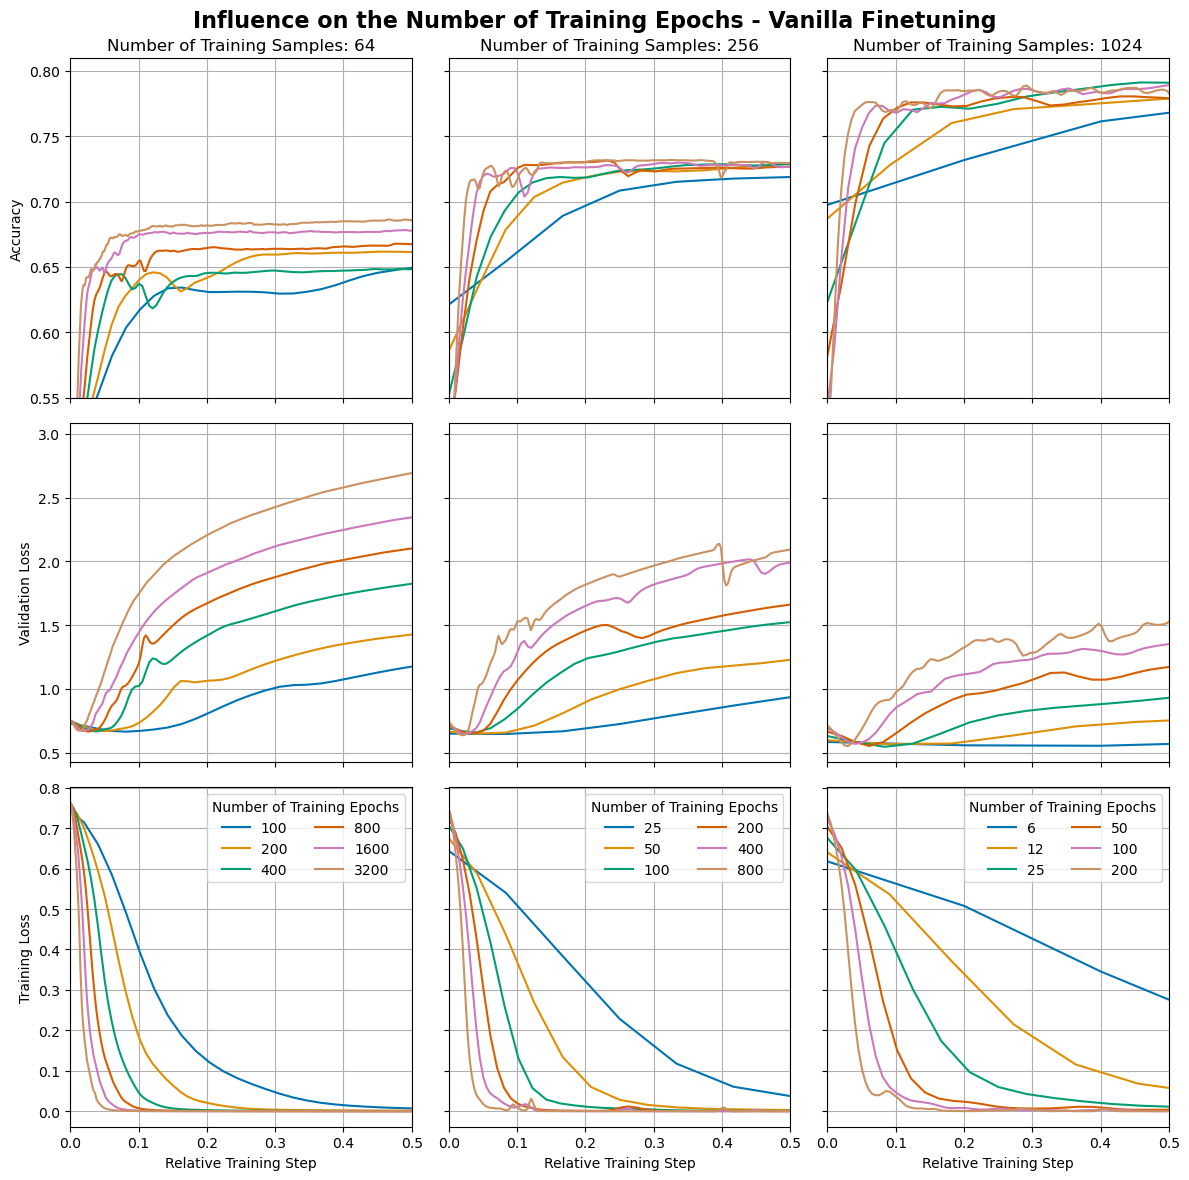

In [42]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d
sns.set_palette('colorblind')
subplot_rows = ['accuracy', 'eval_loss', 'train_st2_loss']
row_names = {
    'accuracy': 'Accuracy',
    'eval_loss': 'Validation Loss',
    'train_st2_loss': 'Training Loss'
}

# Create a new figure
fig, axs = plt.subplots(
    3,
    len(subplot_rows),
    sharex=True,
    sharey='row',
    figsize = (12,12)
    # figsize = (TEXTWIDTH,TEXTWIDTH)
    )

for idy, (train_size, sub_dict) in enumerate(history_dict.items()):
    for idx, metric in enumerate(subplot_rows):
        ax = axs[idx,idy]
        for num_train_epochs, history_df in sub_dict.items():
            metric_columns = history_df.filter(regex=f'{metric}_').copy()
            # Compute the mean, standard deviation, and median
            metric_columns['mean'] = metric_columns.mean(axis=1)
            metric_columns['std'] = metric_columns.std(axis=1)
            metric_columns['median'] = metric_columns.median(axis=1)
        
            # Normalize the index (timesteps) to a range from 0 to 1
            normalized_index = metric_columns.index / metric_columns.index.max()
            # Plot the median on the respective subplot
            # label = f'{int(num_train_epochs*train_size/32)}'
            line, = axs[idx,idy].plot(
                normalized_index,
                gaussian_filter1d(metric_columns['mean'], sigma=1),#metric_columns['mean'],
                label=f'{num_train_epochs}'
                )
            
            # color = line.get_color()
            # axs[idx,idy].plot(normalized_index, metric_columns['mean'] - metric_columns['std'], color=color, linestyle='--')
            # axs[idx,idy].plot(normalized_index, metric_columns['mean'] + metric_columns['std'], color=color, linestyle='--')
            # Add a shaded region for the standard deviation
            # axs[idx,idy].fill_between(normalized_index, (metric_columns['median'] - metric_columns['std']), (metric_columns['median'] + metric_columns['std']), alpha=1)
        if idy == 0:
            ax.set_ylabel(row_names[metric])
        if idx == 0 and idy == 2:
            ax.set_ylim(bottom=0.55)
        if idx == 0:
            ax.set_title(f'Number of Training Samples: {train_size}')
        if idx == len(history_dict) - 1:
            ax.set_xlabel('Relative Training Step')
            # axs[idx,idy].set_xlabel('Epoch')

        ax.grid(True,which='major')
        ax.grid(True,which='minor')
        ax.set_xlim([0,0.5])
        # if idx == 1 and idy == 2:
        #     ax.set_ylim(top=2.7)
        if idx == 2:
            ax.legend(
                loc='upper right',
                ncol=2,
                title='Number of Training Epochs')
fig.suptitle('Influence of the Number of Training Epochs - Vanilla Finetuning', fontsize=16,weight='bold')
# Show the plot
plt.tight_layout()
plt.savefig('img/A_1_testing_num_epochs_vanilla.pdf', format='pdf')
plt.show()

C:\Users\Valentin\AppData\Local\Temp\ipykernel_12352\286309270.py:15: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


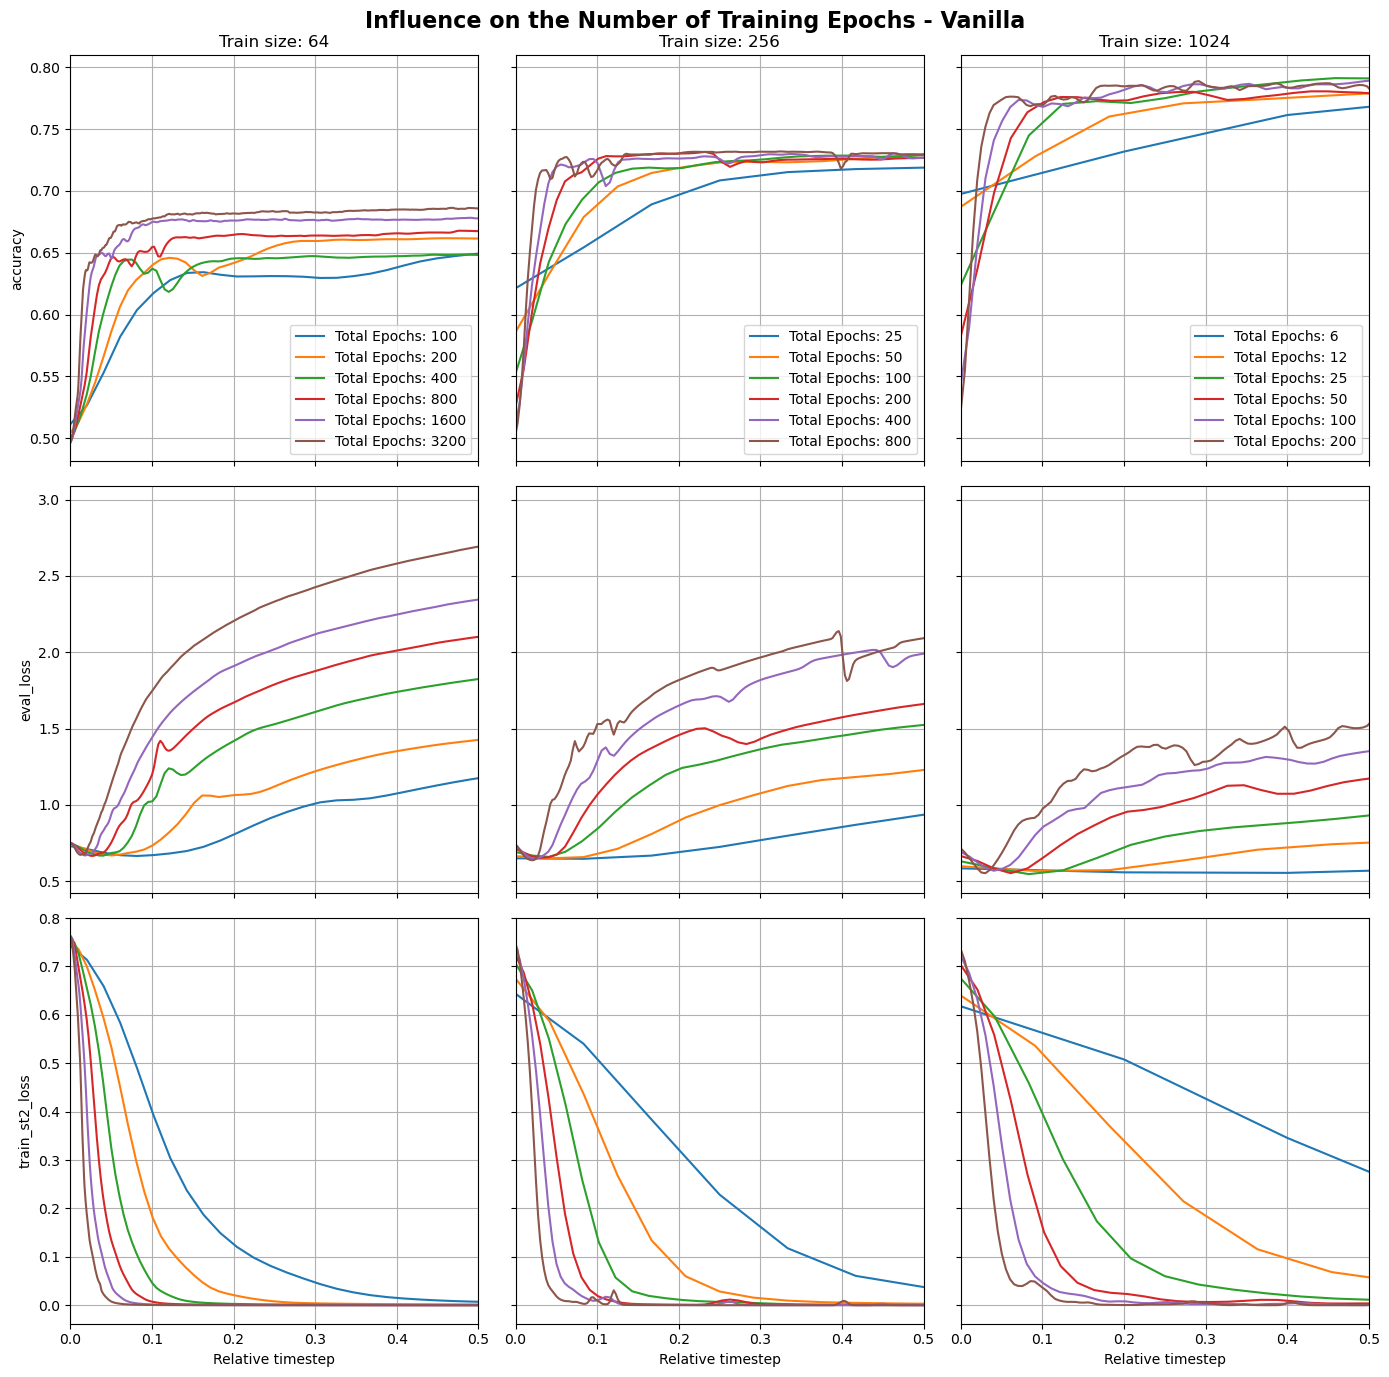

In [28]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'eval_loss', 'train_st2_loss']

# Create a new figure
fig, axs = plt.subplots(
    3,
    len(metrics),
    sharex=True,
    sharey='row',
    figsize = (14,14)
    # figsize = (TEXTWIDTH,TEXTWIDTH)
    )

from scipy.ndimage.filters import gaussian_filter1d

def moving_average(data, window_size):
    return data.rolling(window=window_size).mean().fillna(data)


for idy, (train_size, sub_dict) in enumerate(history_dict.items()):
    for idx, metric in enumerate(metrics):
        for num_train_epochs, history_df in sub_dict.items():
            metric_columns = history_df.filter(regex=f'{metric}_').copy()
            # Compute the mean, standard deviation, and median
            metric_columns['mean'] = metric_columns.mean(axis=1)
            metric_columns['std'] = metric_columns.std(axis=1)
            metric_columns['median'] = metric_columns.median(axis=1)
        
            # Normalize the index (timesteps) to a range from 0 to 1
            normalized_index = metric_columns.index / metric_columns.index.max()
            # Plot the median on the respective subplot
            line, = axs[idx,idy].plot(
                normalized_index,
                gaussian_filter1d(metric_columns['mean'], sigma=1),
                # moving_average(metric_columns['mean'], window_size=5),
                # metric_columns['mean'],
                label=f'Total Epochs: {num_train_epochs}'
                )
            
            # color = line.get_color()
            # axs[idx,idy].plot(normalized_index, metric_columns['mean'] - metric_columns['std'], color=color, linestyle='--')
            # axs[idx,idy].plot(normalized_index, metric_columns['mean'] + metric_columns['std'], color=color, linestyle='--')
            # Add a shaded region for the standard deviation
            # axs[idx,idy].fill_between(normalized_index, (metric_columns['median'] - metric_columns['std']), (metric_columns['median'] + metric_columns['std']), alpha=1)
        if idy == 0:
            axs[idx,idy].set_ylabel(metric)
        if idx == 0:
            axs[idx,idy].set_title(f'Train size: {train_size}')
        if idx == len(history_dict) - 1:
            axs[idx,idy].set_xlabel('Relative timestep')
            # axs[idx,idy].set_xlabel('Epoch')

        axs[idx,idy].grid(True,which='major')
        axs[idx,idy].grid(True,which='minor')
        axs[idx,idy].set_xlim([0,0.5])

        if idx == 0:
            axs[idx,idy].legend(loc='lower right')
fig.suptitle('Influence on the Number of Training Epochs - Vanilla', fontsize=16,weight='bold')
# Show the plot
plt.tight_layout()
plt.savefig('img/A_1_testing_num_epochs_vanilla.pdf', format='pdf')
plt.show()

# Test